<a href="https://colab.research.google.com/github/mdurgasrikari/Durga_Srikari_INFO5731_Spring2024/blob/main/Maguluri_Durga_Exercise_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 In-class Exercise 4**

**This exercise will provide a valuable learning experience in working with text data and extracting features using various topic modeling algorithms. Key concepts such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA), lda2vec, and BERTopic.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## Question 1 (10 Points)

**Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [19]:
# The following code performs topic modeling using Latent Dirichlet Allocation (LDA) on dataset named 20newsgroups data. Only the train subset was
# used for this exercise.  The following preprocessing steps were involved
# Removing emails, new line characters, single qoutes, stop words, biagram, triagrams and finally lemmentization was performed.
# The next step includes building the LDA model with a varied number of topics and selecting
# the best number of topics based on the coherence score. A graph is plotted to understand the relationship between coherence score and number of
# topics and we can see that coherence score is high for 6 topics.The last step includes training the model with with number of topics (in this case 6 topics)
# based on coherence score and provides a summary of the topics.

# Necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_20newsgroups
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
import re
from gensim.utils import simple_preprocess
import spacy

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
# Import Dataset
# Fetch the 20 newsgroups dataset
newsgroups = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

# Extract the content
data = newsgroups.data

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))


# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Function to compute coherence score
def compute_coherence_score(corpus, texts, dictionary, k):
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=k,
                                       random_state=42,
                                       passes=10,
                                       chunksize=100,  # Adjust chunksize
                                       per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

Num Topics  Coherence Value
----------------------------
        2  0.5132
        4  0.5164
        6  0.5709
        8  0.5042
       10  0.4926
       12  0.5100
       14  0.4972
       16  0.4927
       18  0.5008
       20  0.4814

Best number of topics: 6 with coherence score of 0.5709

Topics:
(0, '0.022*"use" + 0.009*"program" + 0.009*"drive" + 0.008*"get" + 0.008*"file" + 0.008*"system" + 0.008*"thank"')
(1, '0.013*"use" + 0.011*"key" + 0.009*"state" + 0.008*"law" + 0.007*"right" + 0.007*"public" + 0.007*"system"')
(2, '0.017*"get" + 0.015*"go" + 0.011*"year" + 0.008*"good" + 0.008*"time" + 0.007*"think" + 0.007*"team"')
(3, '0.643*"ax" + 0.044*"max" + 0.009*"c" + 0.006*"_" + 0.002*"shameful" + 0.002*"intellect" + 0.002*"ai"')
(4, '0.016*"child" + 0.012*"people" + 0.012*"kill" + 0.011*"say" + 0.010*"death" + 0.008*"man" + 0.007*"village"')
(5, '0.011*"know" + 0.011*"say" + 0.010*"people" + 0.009*"think" + 0.009*"make" + 0.008*"see" + 0.007*"evidence"')


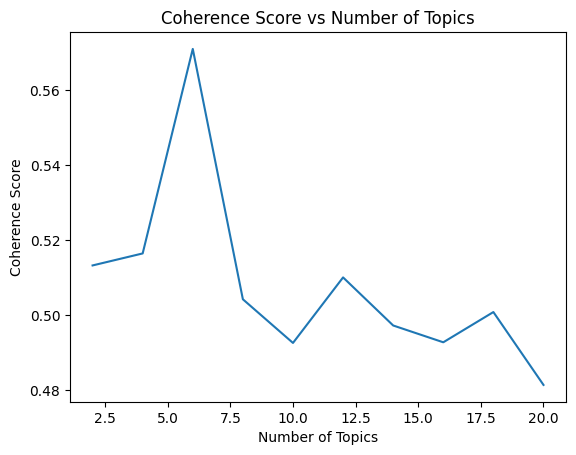


Summarized Topics:
Topic 0: use, program, drive, get, file, system, thank
Topic 1: use, key, state, law, right, public, system
Topic 2: get, go, year, good, time, think, team
Topic 3: ax, max, c, _, shameful, intellect, ai
Topic 4: child, people, kill, say, death, man, village
Topic 5: know, say, people, think, make, see, evidence


In [21]:
# Choose the number of topics based on coherence score
start = 2
stop = 20
step = 2
coherence_scores = []

print("Num Topics  Coherence Value")
print("----------------------------")
for k in range(start, stop+1, step):
    coherence_score = compute_coherence_score(corpus=corpus, texts=texts, dictionary=id2word, k=k)
    coherence_scores.append((k, coherence_score))
    print(f"{k:9}  {coherence_score:.4f}")

best_k, best_coherence = max(coherence_scores, key=lambda x: x[1])
print(f"\nBest number of topics: {best_k} with coherence score of {best_coherence:.4f}")

# Train the final LDA model with the best number of topics
final_lda_model = gensim.models.LdaModel(corpus=corpus,
                                          id2word=id2word,
                                          num_topics=best_k,
                                          random_state=42,
                                          passes=10,
                                          chunksize=100,  # Adjust chunksize
                                          per_word_topics=True)

# Print the topics
topics = final_lda_model.print_topics(num_words=7)
print("\nTopics:")
for topic in topics:
    print(topic)


# Function to plot coherence scores
def plot_coherence_scores(coherence_scores):
    x = [x[0] for x in coherence_scores]
    y = [x[1] for x in coherence_scores]

    plt.plot(x, y)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Score vs Number of Topics")
    plt.show()

# Plot coherence scores
plot_coherence_scores(coherence_scores)


# Summarize topics
print("\nSummarized Topics:")
for i, topic in final_lda_model.show_topics(num_topics=best_k, num_words=7, formatted=False):
    words = ", ".join([word for word, _ in topic])
    print(f"Topic {i}: {words}")

## Question 2 (10 Points)

**Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [36]:
# Write your code here
# The code fetches 20newsgroups dataset and the following preprocessesing steps were performed:
#Tokenizing text, removing stop words, and finally stemming was used by utlizing PorterStemmer
# The code determines the optimal number of topics using Latent Semantic Analysis (LSA) based on coherence scores,
# The next step includes building the LSA model with a varied number of topics and selecting
# the best number of topics based on the coherence score. A graph is plotted to understand the relationship between coherence score and number of
# topics and we can see that coherence score is high for 2 topics.The last step includes training the model with with number of topics (in this case 2 topics)
# based on coherence score and provides a summary of the topics.

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt

def preprocess_text(text):
    """
    Preprocesses the text by tokenizing, removing stopwords, and stemming.
    """
    tokenizer = RegexpTokenizer(r'\w+')  # Initialize regex tokenizer
    en_stop = set(stopwords.words('english'))  # Create English stop words set
    p_stemmer = PorterStemmer()  # Create Porter stemmer

    # Tokenize the text, convert to lowercase, remove stopwords, and stem the words
    tokens = tokenizer.tokenize(text.lower())
    stopped_tokens = [token for token in tokens if token not in en_stop]
    stemmed_tokens = [p_stemmer.stem(token) for token in stopped_tokens]

    return stemmed_tokens

def determine_optimal_topics(dictionary, corpus, texts, start=2, stop=20, step=2):
    """
    Determines the optimal number of topics based on coherence score.
    """
    coherence_values = []
    model_list = []

    # Iterate over a range of topic numbers
    for num_topics in range(start, stop, step):
        # Create LSA model
        model = LsiModel(corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)

        # Compute coherence score
        coherence_model = CoherenceModel(model=model, texts=texts, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())

    # Find the optimal number of topics with the highest coherence score
    optimal_num_topics = start + coherence_values.index(max(coherence_values)) * step
    return optimal_num_topics, coherence_values

def plot_coherence_scores(coherence_scores):
    """
    Plots the coherence scores for different numbers of topics.

    Parameters:
        coherence_scores (list): List of tuples containing (number of topics, coherence score).
    """
    x = [score[0] for score in coherence_scores]
    y = [score[1] for score in coherence_scores]

    plt.plot(x, y, marker='o')  # Add marker for each data point
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Score vs Number of Topics")
    plt.grid()  # Add grid lines
    plt.show()

In [37]:
# Step 1: Fetch the 20 newsgroups dataset
newsgroups = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

# Step 2: Preprocess the text
clean_text = []
for doc in newsgroups.data:
    clean_text.append(preprocess_text(doc))

# Step 3: Create a document-term matrix using CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
doc_term_matrix = vectorizer.fit_transform([" ".join(doc) for doc in clean_text])

# Step 4: Convert the document-term matrix to a gensim corpus and create a dictionary
corpus = gensim.matutils.Sparse2Corpus(doc_term_matrix.T)
dictionary = gensim.corpora.Dictionary.from_corpus(corpus, id2word=dict((id, word) for word, id in vectorizer.vocabulary_.items()))

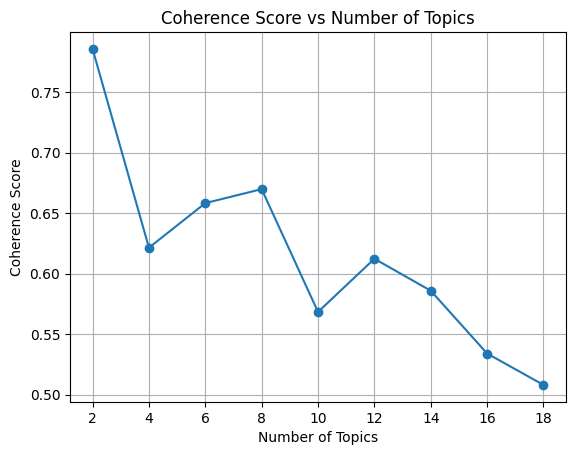


Coherence scores for each topic:
Number of topics: 2, Coherence Score: 0.7857
Number of topics: 4, Coherence Score: 0.6215
Number of topics: 6, Coherence Score: 0.6583
Number of topics: 8, Coherence Score: 0.6699
Number of topics: 10, Coherence Score: 0.5684
Number of topics: 12, Coherence Score: 0.6123
Number of topics: 14, Coherence Score: 0.5859
Number of topics: 16, Coherence Score: 0.5341
Number of topics: 18, Coherence Score: 0.5081

 Optimal number of topics: 2

Topics generated by LSA model:
Topic 1: ax, max, g9v, b8f, a86, pl, 1d9, 1t, 145, bhj
Topic 2: file, use, edu, program, imag, avail, includ, inform, window, entri


In [38]:
# Step 5: Determine the optimal number of topics
start = 2
stop = 20
step = 2
optimal_num_topics, coherence_values = determine_optimal_topics(dictionary, corpus, clean_text, start, stop, step)

# Plot coherence scores
coherence_scores = list(zip(range(start, stop+1, step), coherence_values))
plot_coherence_scores(coherence_scores)

# Print coherence scores for each topic
print("\nCoherence scores for each topic:")
for num_topics, coherence_score in zip(range(start, stop+1, step), coherence_values):
    print(f"Number of topics: {num_topics}, Coherence Score: {coherence_score:.4f}")

# Print best number of topics
print(f"\n Optimal number of topics: {optimal_num_topics}")


# Step 6: Create an LSA model with the optimal number of topics
lsa_model = LsiModel(corpus, num_topics=optimal_num_topics, id2word=dictionary)

# Step 7: Extract and summarize the topics
topics = lsa_model.show_topics(formatted=False)
print("\nTopics generated by LSA model:")
for topic_id, topic in topics:
    print(f"Topic {topic_id + 1}: {', '.join([word for word, _ in topic])}")

## **Question 3 (Alternative) - (10 points)**

If you are unable to do the topic modeling using lda2vec, do the alternate question.

Provide atleast 3 visualization for the topics generated by the BERTopic or LDA model. Explain each of the visualization in detail.


I have chosen the alternative question and below are 5 visualizations for the topics generated for the LDA model. I have visualized following types of visualizations.

Coherence Graph: Relationship between coherence score and the number of topics chosen. This graph helps us to understand what are the optimal number of topics for any dataset based on the coherence score. Higher coherence score is always preferred. (This graph is provided after cell 21)

Word cloud - A word cloud represents most occured words (generally top 10) for a topic across documents considered. The font size of the word determines the high occurance of a word.

Pie chart - The pie chart provides a topic distribution across documents with the percentage and the number of documents that each particular topic has.

Distance map - In this graph we are trying to visualize the distance between various topics chosen.

Bar chart - In this type of visualization, we are visualizing the average distribution of documents across differnet topics.

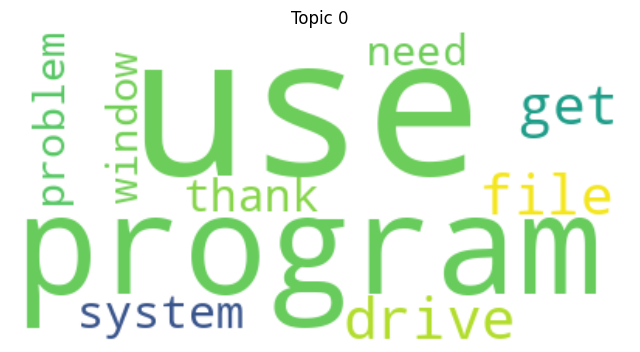

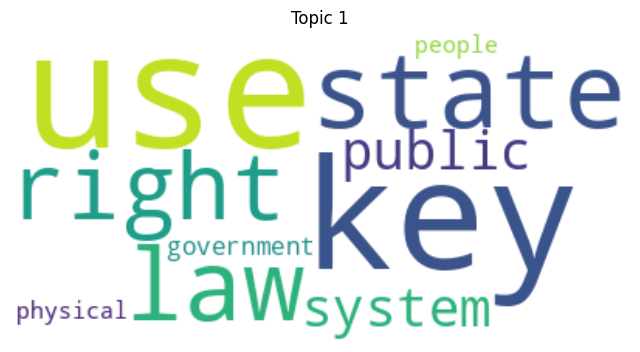

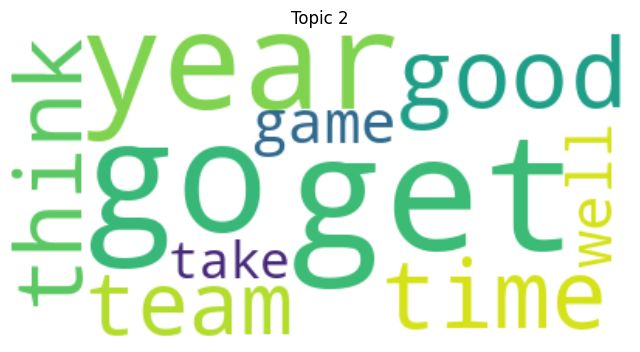

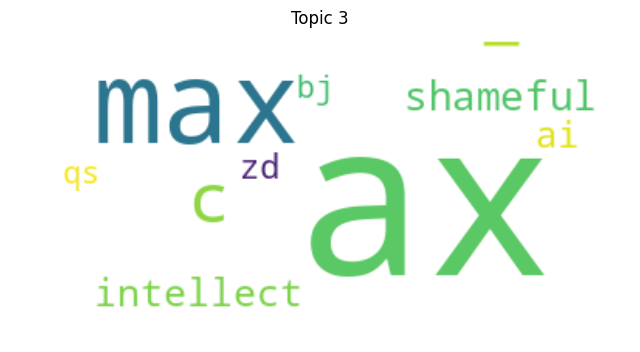

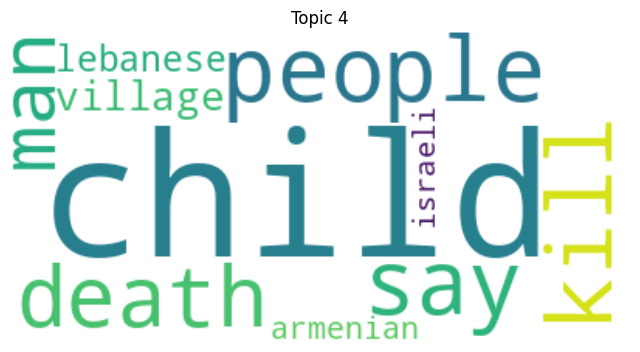

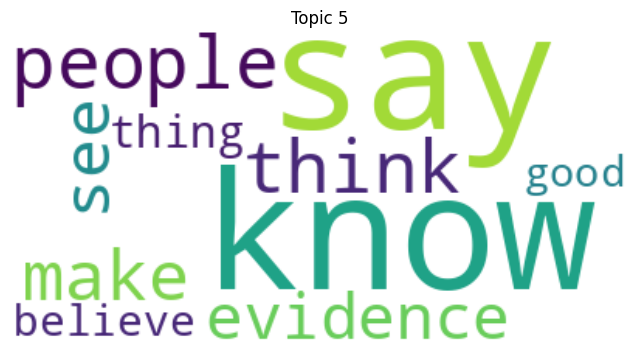

In [32]:

# Following is the summary of topics based on LDA model. ( Higher the font size, more the occuracnce of these words across the topic)

#Following key words occure the most for Topic 0 in the order of their most occurance: use, program, drive, get, file, system, thank, window, problem, need
#Following key words occure the most for Topic 1 in the order of their most occurance: use, key, state, law, right, public, system, physical, government, people
#Following key words occure the most for Topic 2 in the order of their most occurance: get, go, year, good, think, time, team, well, take, game
#Following key words occure the most for Topic 3 in the order of their most occurance: ax, max, c, _, shameful, intellect, ai, zd, qs, bj
#Following key words occure the most for Topic 4 in the order of their most occurance: child, people, kill, say, death, man, village, labanese, armanean, israeli
#Following key words occure the most for Topic 5 in the order of their most occurance: know, say, people, think, make, see, evidence, good, beleive, thing,

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate word clouds for each topic
def generate_wordclouds(lda_model, num_topics):
    for topic_id in range(num_topics):
        plt.figure(figsize=(8, 6))
        wordcloud = WordCloud(background_color="white", max_words=15).generate_from_frequencies(dict(lda_model.show_topic(topic_id)))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Topic {topic_id}')
        plt.axis("off")
        plt.show()

# Generate word clouds for each topic
generate_wordclouds(final_lda_model, best_k)

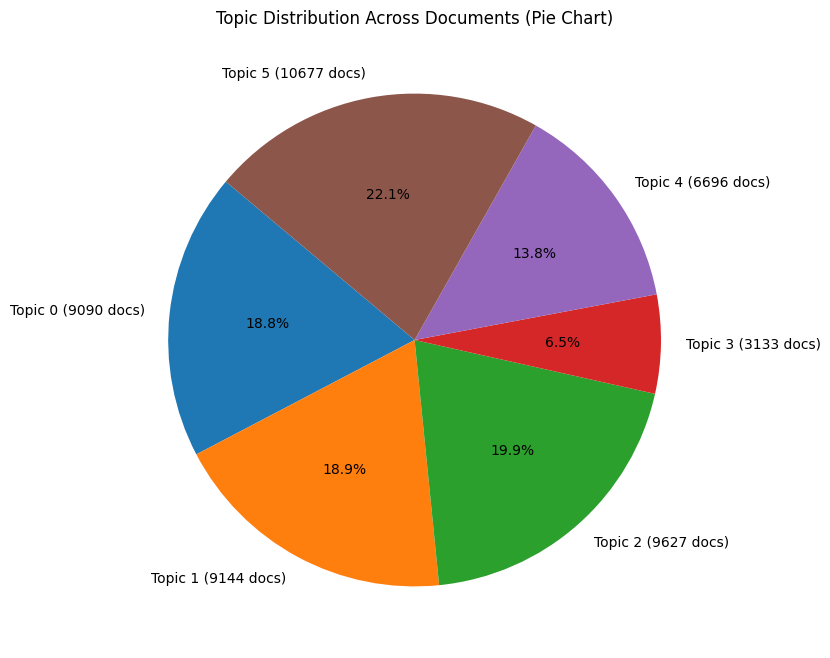

In [23]:
# Based on the below pie chart, we can see that, overall 48367 documents were considered by the LDS model and the statistics are as follows

# Topic 5 is the highest count of documents, that accounts for 22.1% and was found in 10,677 documents
# Followed by Topic 2 that accounts for 19.9% and was found in 9627 documents
# Topic 1 that accounts for 18.9% and was found in 9144 documents
# This is closely followed by Topic 0 that accounts for 19.8% and was found in 9090 documents
# Topic 4 that accounts for 13.8% and was found in 6696 documents
# Topic 3 that accounts for 6.5% and was found in 3133 documents

import numpy as np
import matplotlib.pyplot as plt

def visualize_topic_distribution_pie(lda_model, corpus, num_topics):
    # Initialize array to store topic distribution across documents
    topic_distribution = np.zeros(num_topics)

    # Populate topic distribution array
    total_documents = len(corpus)
    for doc in corpus:
        topics = lda_model.get_document_topics(doc)
        for topic, prob in topics:
            topic_distribution[topic] += 1

    # Plot topic distribution as a pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(topic_distribution, labels=[f'Topic {i} ({int(count)} docs)' for i, count in enumerate(topic_distribution)], autopct='%1.1f%%', startangle=140)
    plt.title('Topic Distribution Across Documents (Pie Chart)')
    plt.show()

# Visualize topic distribution as a pie chart
visualize_topic_distribution_pie(final_lda_model, corpus, num_topics=best_k)


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


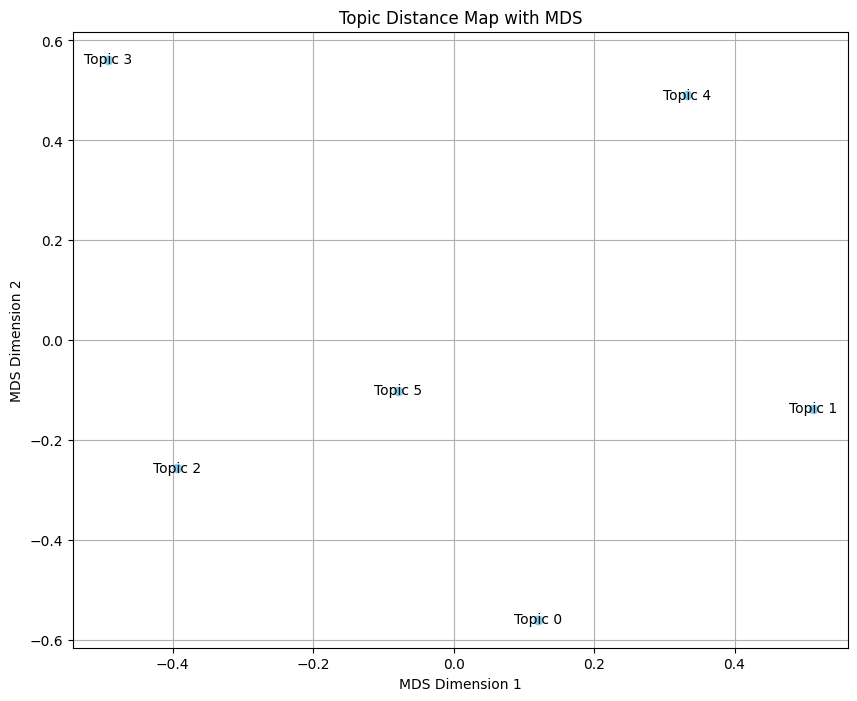

In [24]:

# This distance map provides the insights into the
# underlying struture of the relationship between the best topics. We will be using Multidimensional scaling (MDS) to reduce the dimensionality to 2D.
# The topics are well dispersed and we can see that are well aligned.
# Example: We can see that that  topic 2 and topic 5 are closely aligned.


import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

def visualize_topic_distance_map(lda_model, num_topics):
    # Get topic-word matrix
    topic_word_matrix = lda_model.get_topics()

    # Compute pairwise cosine similarity between topics
    similarity_matrix = np.dot(topic_word_matrix, topic_word_matrix.T)
    norm = np.outer(np.linalg.norm(topic_word_matrix, axis=1), np.linalg.norm(topic_word_matrix, axis=1))
    similarity_matrix /= norm

    # Apply MDS to reduce dimensionality to 2D
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    topics_2d = mds.fit_transform(1 - similarity_matrix)

    # Plot topic distance map
    plt.figure(figsize=(10, 8))
    plt.scatter(topics_2d[:, 0], topics_2d[:, 1], marker='o', color='skyblue')
    for i, (x, y) in enumerate(topics_2d):
        plt.text(x, y, f'Topic {i}', fontsize=10, ha='center', va='center')
    plt.title('Topic Distance Map with MDS')
    plt.xlabel('MDS Dimension 1')
    plt.ylabel('MDS Dimension 2')
    plt.grid(True)
    plt.show()

# Visualize topic distance map
visualize_topic_distance_map(final_lda_model, num_topics=best_k)

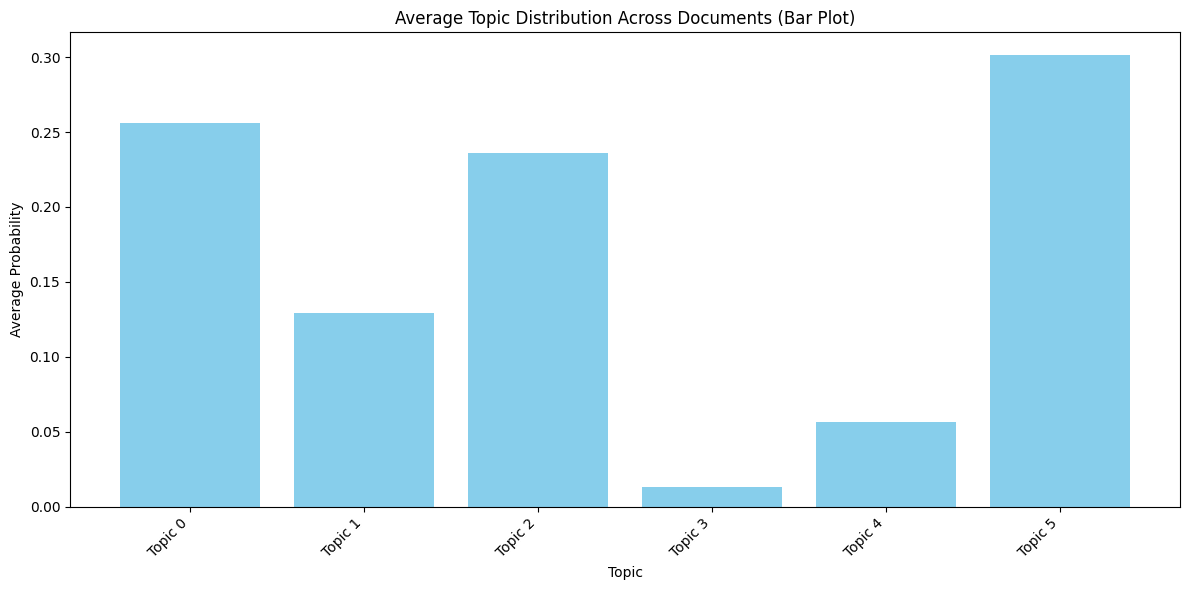

In [25]:
# Write your code here
# While the pie chart showed that Topic 5 was well distributed, when average is considered.
# followed by topic 2, topic 0, Topic 2, Topic 1, Topic 4, Topic 3.


def visualize_topic_distribution_bar(lda_model, corpus, num_topics):
    # Get topic distribution for each document
    topic_distribution = [lda_model.get_document_topics(doc) for doc in corpus]

    # Prepare data for plotting
    topic_probs = np.zeros((len(corpus), num_topics))
    for i, doc_topics in enumerate(topic_distribution):
        for topic, prob in doc_topics:
            topic_probs[i][topic] = prob

    # Plot topic distribution as a bar plot
    plt.figure(figsize=(12, 6))
    avg_topic_probs = np.mean(topic_probs, axis=0)
    plt.bar(np.arange(num_topics), avg_topic_probs, color='skyblue')  # Use np.arange to ensure all topics are displayed
    plt.title('Average Topic Distribution Across Documents (Bar Plot)')
    plt.xlabel('Topic')
    plt.ylabel('Average Probability')

    # Rotate x-axis labels for better readability
    plt.xticks(np.arange(num_topics), [f'Topic {i}' for i in range(num_topics)], rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# Visualize topic distribution across documents as a bar plot
visualize_topic_distribution_bar(final_lda_model, corpus, num_topics=best_k)

## Question 4 (10 points):
**Generate K topics by using BERTopic, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing

In [29]:
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 15.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 14.4 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731

In [41]:
# Write your code here
# In this program we are using BERTopic model to determine optimal topics using the 20newsgroups dataset. It uses UMAP, countervectorization
# and feature extraction. It calculates the coherance score of different topics and selects optimal number of topics. Finally it summarizes
# the optimal topics with the using the coherance score and a line graph is plotted based on cohence and number of topics.

from bertopic import BERTopic
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
import matplotlib.pyplot as plt

# Prepare documents
docs = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))['data']

# Prepare embeddings
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(docs, show_progress_bar=True)

# Initialize BERTopic model with UMAP and CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 2))
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
topic_model = BERTopic(umap_model=umap_model, vectorizer_model=vectorizer_model, verbose=True, min_topic_size=50)

# Fit BERTopic model with different numbers of topics and evaluate coherence
coherence_scores = []
optimal_num_topics = None
optimal_coherence_score = -1

for num_topics in range(2, 20):  # Try different numbers of topics from 2 to 20
    topic_model.nr_topics = num_topics
    topics, probs = topic_model.fit_transform(docs, embeddings)

    # Preprocess documents
    documents = pd.DataFrame({"Document": docs, "ID": range(len(docs)), "Topic": topics})
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

    # Extract vectorizer and analyzer from BERTopic
    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    # Extract features for Topic Coherence evaluation
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]

    # Extract words in each topic if they are non-empty and exist in the dictionary
    topic_words = []
    for topic in range(len(set(topics)) - topic_model._outliers):
        words = list(zip(*topic_model.get_topic(topic)))[0]
        words = [word for word in words if word in dictionary.token2id]
        topic_words.append(words)
    topic_words = [words for words in topic_words if len(words) > 0]

    # Evaluate Coherence
    coherence_model = CoherenceModel(topics=topic_words, texts=tokens, corpus=corpus,
                                     dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()
    coherence_scores.append(coherence)

    # Update optimal number of topics and coherence score
    if coherence > optimal_coherence_score:
        optimal_num_topics = num_topics
        optimal_coherence_score = coherence

# Print optimal number of topics and coherence score
print(f"Optimal number of topics: {optimal_num_topics}")
print(f"Coherence score for Best number of topics: {optimal_coherence_score}")

# Fit BERTopic model with the optimal number of topics
topic_model.nr_topics = optimal_num_topics
topics, probs = topic_model.fit_transform(docs, embeddings)

# Preprocess documents
documents = pd.DataFrame({"Document": docs, "ID": range(len(docs)), "Topic": topics})
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

# Extract features for Topic Coherence evaluation
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]

# Extract words in each topic if they are non-empty and exist in the dictionary
topic_words = []
for topic in range(len(set(topics)) - topic_model._outliers):
    words = list(zip(*topic_model.get_topic(topic)))[0]
    words = [word for word in words if word in dictionary.token2id]
    topic_words.append(words)
topic_words = [words for words in topic_words if len(words) > 0]

Batches:   0%|          | 0/354 [00:00<?, ?it/s]

2024-03-30 01:41:18,956 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-30 01:41:32,541 - BERTopic - Dimensionality - Completed ✓
2024-03-30 01:41:32,543 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-30 01:41:33,300 - BERTopic - Cluster - Completed ✓
2024-03-30 01:41:33,302 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-30 01:41:48,672 - BERTopic - Representation - Completed ✓
2024-03-30 01:41:48,710 - BERTopic - Topic reduction - Reducing number of topics
2024-03-30 01:42:02,343 - BERTopic - Topic reduction - Reduced number of topics from 18 to 2
2024-03-30 01:42:35,429 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-30 01:42:49,709 - BERTopic - Dimensionality - Completed ✓
2024-03-30 01:42:49,716 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-30 01:42:50,908 - BERTopic - Cluster - Completed ✓
2024-03-30 01:42:50

Optimal number of topics: 10
Coherence score for Best number of topics: 0.8290344981430945


2024-03-30 02:06:38,789 - BERTopic - Dimensionality - Completed ✓
2024-03-30 02:06:38,793 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-30 02:06:40,088 - BERTopic - Cluster - Completed ✓
2024-03-30 02:06:40,090 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-30 02:06:55,127 - BERTopic - Representation - Completed ✓
2024-03-30 02:06:55,171 - BERTopic - Topic reduction - Reducing number of topics
2024-03-30 02:07:11,389 - BERTopic - Topic reduction - Reduced number of topics from 18 to 10



Topic Summary:
Topic 0: Coherence Score = 0.8009372906369672
Top Words: use, file, windows, drive, like, thanks, does, program, using, know

Topic 1: Coherence Score = 0.7493277004093435
Top Words: people, dont, government, key, think, just, gun, right, president, know

Topic 2: Coherence Score = 0.7961275163160656
Top Words: car, bike, just, like, cars, good, dont, engine, know, dod

Topic 3: Coherence Score = 0.8577827252069661
Top Words: team, game, games, season, year, play, players, hockey, 10, 25

Topic 4: Coherence Score = 0.8634405076063585
Top Words: god, jesus, people, bible, believe, does, say, faith, church, christian

Topic 5: Coherence Score = 0.814645582896923
Top Words: patients, msg, medical, health, food, disease, dont, pain, doctor, people

Topic 6: Coherence Score = 0.8058522799220895
Top Words: armenian, people, armenians, turkish, said, israel, jews, israeli, turkey, know

Topic 7: Coherence Score = 0.9399226600740873
Top Words: space, launch, nasa, lunar, orbit,

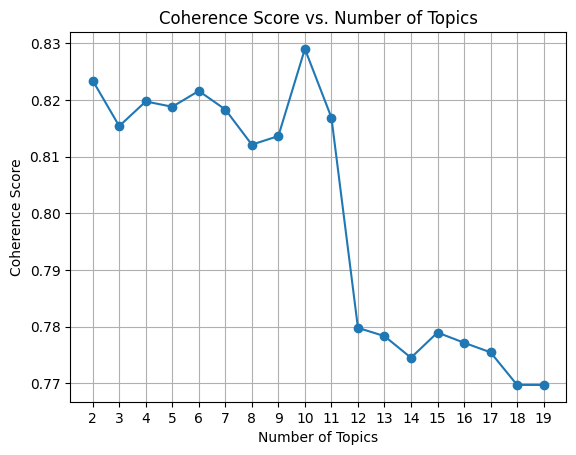

In [42]:
# Evaluate Coherence for optimal topics
coherence_model = CoherenceModel(topics=topic_words, texts=tokens, corpus=corpus,
                                 dictionary=dictionary, coherence='c_v')
coherence = coherence_model.get_coherence()

# Print topics along with their coherence scores
print("\nTopic Summary:")
for topic_id, top_words in enumerate(topic_words):
    coherence_score = coherence_model.get_coherence_per_topic()[topic_id]
    print(f"Topic {topic_id}: Coherence Score = {coherence_score}")
    print(f"Top Words: {', '.join(top_words)}\n")

# Plot coherence scores for different numbers of topics
plt.plot(range(2, 20), coherence_scores, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(range(2, 20))
plt.grid(True)
plt.show()

## Question 3 (10 points):
**Generate K topics by using lda2vec, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://nbviewer.org/github/cemoody/lda2vec/blob/master/examples/twenty_newsgroups/lda2vec/lda2vec.ipynb

## Extra Question (5 Points)

**Compare the results generated by the four topic modeling algorithms, which one is better? You should explain the reasons in details.**

**This question will compensate for any points deducted in this exercise. Maximum marks for the exercise is 40 points.**

In [ ]:
# Write your code here
'''

To compare any topics in topic modelling these are few factors that needs to be considered in general. The below factors are chosen based my experience working on this exercise.

Coherence Score: This measure indicates topic interpretation and similarities in the semantic structure of most occurred words of a topic. A high coherence score implies that the topics are strongly
aligned with each other.
Topic Interpretation: This measure indicates if the topics generated by each topic modelling are coherent and easily interpretable. Can these topic models accurately suumarize based on the
best words associated with each topic.
Scalable: This measure indicates if the topic models can handle datasets effectively and efficiently.

From the above mentioned measures, when we consider coherence score and topic interpretability, BerTopic is more efficient than the other two topic models (namely LDA and LSA). But when
considering scalability BerTopic appears to be less efficient than LDA and LSA models as it has taken significant amount of time when compared to the other two models to run the same
dataset.


'''

# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.

Consider the following points in your response:

**Learning Experience:** Describe your overall learning experience in working with text data and extracting features using various topic modeling algorithms. Did you understand these algorithms and did the implementations helped in grasping the nuances of feature extraction from text data.

**Challenges Encountered:** Were there specific difficulties in completing this exercise?

Relevance to Your Field of Study: How does this exercise relate to the field of NLP?

**(Your submission will not be graded if this question is left unanswered)**



In [ ]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
Please write you answer here:

while working on this exercise,

Learning Experience: During this exercise, I have learned what are the various steps involved in implementation of LDA, LSA, and BerTopic for topic modeling. Prior to implementation of these
algorithms I had to understand what are various preprocessing steps that are required to run on this data. For example, following are few steps I used for preprocessing the data: Removing
emails, next line charaters, stop words, biagram, triagrams, lemmentization and stemming. I have also learned about the importance of coherence score which can help understand the optimal
number of topics required for a dataset. I have also visualized the optimal topics chosen using LDA model which helped me understand more about these topics and topic modelling in general.

Challenges Encountered: While working on this exercise, I could not implement the lda2vec model even though I have referred to various sources on google. For the BerTopic model the notebook
which was provided didn't have theory/explanation on how to use coherence score to identify optimal topics for a dataset. I had to go through the following
GitHub link https://github.com/MaartenGr/BERTopic/issues to understand on how to use coherence score as an evaluation metrics to identify the optimal topics for the above data set. BerTopic
model took close to an hour to run the code, and other Topic models also took close to 20 minutes each to run. Completing this within one day's timeline and implementing these new concepts
for the first time was challenging.


'''